## 1. Descripción del dataset

El dataset a tratar en la práctica es  https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset.

Se trata de un dataset con 14 variables, las cuales estan asociadas a pancientes con síntomas coronarios y cuyo objetivo es la predicción de la probabilidad (mayor o menor) de tener un ataque al corazón bajo esos síntomas. El dataset es de mucha relevancia, dado que poder entrerar un modelo que anticipe esta circunstancia podría ayudar a salvar muchas vidas. 

El dataset consta de las siguientes variables:
- **age** : Edad del paciente
- **sex**: Sexo del paciente codificado como 0 o 1. Se desconoce su traducción a Hombre o Mujer.
- **cp** : Chest Pain type chest pain type. Tipo de dolor en el pecho. Puede tomar los valores:
    - Valor 0: typical angina
    - Valor 1: atypical angina
    - Valor 2: non-anginal pain
    - Valor 3: asymptomatic
     
    > Aunque en el dataset de referenca de Kaggle de indica que el rango de valores de la variable es [1..4],  analizando el fichero se observa que es [0..3]
    
- **trtbps** : resting blood pressure (in mm Hg). Presion sanguinea en reposo.
- **chol** : cholestoral in mg/dl fetched via BMI sensor. Colesterol en sangre.
- **fbs** : (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false). Azugar en sangre en ayunas por encima de 129 mg/dl. Codificado como 1 Verdadero, 0 Falso.
- **restecg** : resting electrocardiographic results. Resultados del electrocardiograma en reposo. Puede tomar los siguientes valores:
    - Valor 0: normal
    - Vaslor 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    - Valor 2: showing probable or definite left ventricular hypertrophy by Estes' criteria.

- **thalachh** : maximum heart rate achieved. Frecuencia cardiaca máxima.
- **exng**:  "exercise induced angina". Angina inducida por el ejercicio. Codificado como 1 "Si" 0 "No".
- **caa**: number of major vessels. Numero de vasos sanguineos mayores. Codificado de 0 a 4. 

    > En la descripción del dataset de Kaggle se indica que que el rango de la variable es 0..3, sin embargo observando el fichero, se codifica de 0..4. Esto es mas coherente, ya que los vasos mayores del corazón son 5.
    
- **target** :  Variable objetivo. 0 = menor posibilidad de ataque al corazón 1 = mayor posibilidad de ataque al corazon.

El dataset consta de otras tres variables que no están descritas y no conocemos su significado (oldpoeak, slp y thall) que no utilizaremos por pruedencia.

A continuación, vamos a visualizar los primeros datos del dataset

In [190]:
import pandas as pd
import matplotlib.pyplot as plt

In [191]:
df = pd.read_csv("./datos/heart.csv")

In [192]:
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


Borramos las columnas que no vamos a utlizar

In [193]:
df = df.drop(["oldpeak", "slp", "thall"], axis=1)

## 2. Integración y selección

Vamos a integrar los ficheros que contienen las descriciones de los campos categoricos del dataset, de manera que sea más fácil su interpretación y trabajo con los datos.

Después de la integración de cada fichero, borraremos la columna de cruce del fichero integrado, para no duplicar la columna.

**Exang**

In [194]:
df_exang = pd.read_csv("./datos/exang.csv")

In [195]:
df = df.merge(df_exang, how="left", left_on="exng", right_on="id_exang").drop(["id_exang"], axis=1)

**Chest pain**

In [196]:
df_cp = pd.read_csv("./datos/chest_pain.csv")

In [197]:
df = df.merge(df_cp, left_on="cp", right_on="id_cp", how="left").drop(["id_cp"], axis=1)

Visualizamos el dataset final

In [234]:
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,caa,output,desc_exang,desc_cp
0,63,1,3,145,233,1,0,150,0,0,1,no,asymptomatic
1,37,1,2,130,250,0,1,187,0,0,1,no,non-anginal pain
2,41,0,1,130,204,0,0,172,0,0,1,no,atypical angina
3,56,1,1,120,236,0,1,178,0,0,1,no,atypical angina
4,57,0,0,120,354,0,1,163,1,0,1,yes,typical angina


## 3. Limpieza de los datos.

### NULOS

Obenemos un listado de las columnas que tienen nulos y el porcentaje que representan sobre el total de datos.

In [229]:
df.apply(lambda x: sum(x.isnull()/len(x)))

age           0.0
sex           0.0
cp            0.0
trtbps        0.0
chol          0.0
fbs           0.0
restecg       0.0
thalachh      0.0
exng          0.0
caa           0.0
output        0.0
desc_exang    0.0
desc_cp       0.0
dtype: float64

No hay datos nulos

***TODO: Imputar NAs random y utilizar un algoritmo de clusterización tipo KNN para imputar los valores nulos***

### PERDIDOS

Vamos a identificar valores extraños que puedan significar perdida de datos:

**age**

In [203]:
df.age.describe()

count    303.000000
mean      54.366337
std        9.082101
min       29.000000
25%       47.500000
50%       55.000000
75%       61.000000
max       77.000000
Name: age, dtype: float64

Minimo y máximo en rangos coherentes. La información parece correcta.

**sex**

In [202]:
df.sex.unique()

array([1, 0], dtype=int64)

Correcta

**cp**

In [205]:
df.cp.unique()

array([3, 2, 1, 0], dtype=int64)

Valores en rango. Parece correcta.

**trtbps**

In [206]:
df.trtbps.describe()

count    303.000000
mean     131.623762
std       17.538143
min       94.000000
25%      120.000000
50%      130.000000
75%      140.000000
max      200.000000
Name: trtbps, dtype: float64

El rango de presión arterial parece normal. No vemos valores raros.

**chol**

In [208]:
df.chol.describe()

count    303.000000
mean     246.264026
std       51.830751
min      126.000000
25%      211.000000
50%      240.000000
75%      274.500000
max      564.000000
Name: chol, dtype: float64

No se observan valores extraños.

**fbs**

In [210]:
df.fbs.unique()

array([1, 0], dtype=int64)

Valores esperados. Todo ok.

**restecg**

In [212]:
df.restecg.unique()

array([0, 1, 2], dtype=int64)

Valores esperados. Todo ok.

**thalachh**

In [214]:
df.thalachh.describe()

count    303.000000
mean     149.646865
std       22.905161
min       71.000000
25%      133.500000
50%      153.000000
75%      166.000000
max      202.000000
Name: thalachh, dtype: float64

El rango [71..202] parece normal.

**exng**

In [216]:
df.exng.unique()

array([0, 1], dtype=int64)

Valores esperados. Todo ok

**caa**

In [219]:
df.caa.unique()

array([0, 2, 1, 3, 4], dtype=int64)

Valores en rango. Todo correcto

**output**

In [222]:
df.output.unique()

array([1, 0], dtype=int64)

Valores en rango. Todo ok.

***
Conclusión: No hay ni nulos ni valores que representen pérdida de información. No se realizará ningún tratamiento sobre los datos
***

### VALORES EXTREMOS

Vamos a revisar las variables numéricas, para identificar posibles valores extremos, que identifiquen un error de dato. Vamos a realizar el análisis a traves de diagramas de caja

**age**

<AxesSubplot: >

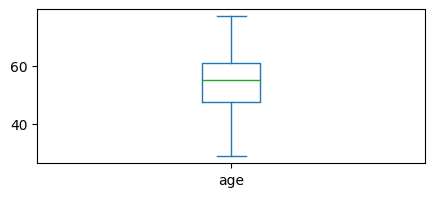

In [233]:
df.age.plot.box(figsize=(5, 2))

No se observan valores atípicos

**trtbps** (presión sanguinea en reposos)

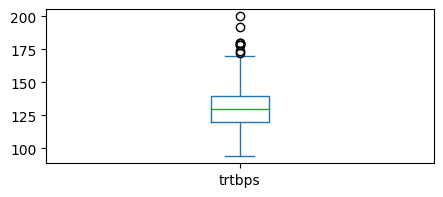

In [237]:
bp = df.trtbps.plot.box(figsize=(5, 2))

Se observan valores atípicos superiores. Vamos a listarlos:

In [240]:
from matplotlib.cbook import boxplot_stats

In [241]:
boxplot_stats(df.trtbps)

[{'mean': 131.62376237623764,
  'iqr': 20.0,
  'cilo': 128.1961171325887,
  'cihi': 131.8038828674113,
  'whishi': 170,
  'whislo': 94,
  'fliers': array([172, 178, 180, 180, 200, 174, 192, 178, 180], dtype=int64),
  'q1': 120.0,
  'med': 130.0,
  'q3': 140.0}]

## 4. Análisis de los datos.

Se realizará durante toda la práctica

## 6. Resolución del problema